# 06.1s: Singularity Intrinsic Dimensionality

**Goal:** Compute the intrinsic dimensionality of the black hole and cuckoo structures using participation ratio.

We know these tokens form a tight cluster at r ≈ 0.3709 from the gamma origin, but we don't know how many dimensions they actually occupy. They live in 2560D space, but the cluster itself might be effectively lower-dimensional.

**Participation Ratio:** PR = (Σλᵢ)² / Σλᵢ²
- If all eigenvalues equal: PR = d (full dimensionality)
- If only one non-zero: PR = 1 (one dimension)
- Measures effective dimensionality

We'll compute PR for:
1. **13 unique black hole vectors** (deduped degenerate clusters)
2. **All 2,100 black hole tokens** (with degeneracy)
3. **27 cuckoo tokens**
4. **Black holes + cuckoos combined** (2,127 tokens)

**Additional explorations:**
- What's the intrinsic shape? (Ellipsoid? Sphere? Filament?)
- How aligned are the black hole and cuckoo principal axes?
- What's the volume occupied (in gamma units)?

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# Zone boundaries
BLACK_HOLE_R = 1e-4
CUCKOO_R = 1e-3

# How many eigenvalues to show
N_EIGENVALUES_SHOW = 20

# Visualization
DPI = 100

# Random seed
RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Extract Zones

In [3]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
black_hole_unique_indices = []  # Store unique indices for the 13 clusters

for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)
    black_hole_unique_indices.append(unique_idx)

black_hole_token_ids = sorted(black_hole_token_ids)

# Get the 13 unique vectors
unique_black_hole_vecs = torch.from_numpy(unique_vecs[black_hole_unique_indices])

print(f"Identified {len(black_hole_token_ids)} black hole tokens")
print(f"  Collapsed into {len(unique_black_hole_vecs)} unique vectors")

# Compute black hole centroid
black_hole_embeddings = gamma[black_hole_token_ids]
bh_centroid = black_hole_embeddings.mean(dim=0)

print(f"\nBlack hole centroid norm: {torch.norm(bh_centroid).item():.12f}")

# Extract cuckoos
distances_from_bh = torch.norm(gamma - bh_centroid, dim=1)
cuckoo_mask = (distances_from_bh > BLACK_HOLE_R) & (distances_from_bh <= CUCKOO_R)
cuckoo_token_ids = torch.where(cuckoo_mask)[0].tolist()
cuckoo_embeddings = gamma[cuckoo_mask]

print(f"\nFound {len(cuckoo_token_ids)} cuckoo tokens")

# Combined set
combined_embeddings = torch.cat([black_hole_embeddings, cuckoo_embeddings], dim=0)
print(f"\nCombined set: {len(combined_embeddings)} tokens")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Finding degenerate clusters...

Identified 2100 black hole tokens
  Collapsed into 13 unique vectors

Black hole centroid norm: 0.370916873217

Found 27 cuckoo tokens

Combined set: 2127 tokens


## Step 2: PCA Helper Functions

In [4]:
def compute_pca(embeddings, name=""):
    """
    Compute PCA on a set of embeddings.
    Returns eigenvalues, eigenvectors, explained variance ratios, and participation ratio.
    """
    n_tokens, d = embeddings.shape
    
    if n_tokens < 2:
        print(f"\n{'='*70}")
        print(f"PCA: {name}")
        print(f"{'='*70}")
        print(f"ERROR: Need at least 2 tokens for PCA, got {n_tokens}")
        return None, None, None, None
    
    print(f"\n{'='*70}")
    print(f"PCA: {name}")
    print(f"{'='*70}")
    print(f"Tokens: {n_tokens}")
    print(f"Dimensions: {d}")
    print()
    
    # Center
    mean = embeddings.mean(dim=0)
    centered = embeddings - mean
    
    # Covariance matrix
    cov = (centered.T @ centered) / (n_tokens - 1)
    
    # Eigendecomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    
    # Sort descending
    eigenvalues = eigenvalues.flip(0)
    eigenvectors = eigenvectors.flip(1)
    
    # Explained variance
    total_var = eigenvalues.sum()
    explained_var = eigenvalues / total_var
    
    # Participation ratio: PR = (Σλ)² / Σλ²
    sum_eigenvalues = eigenvalues.sum().item()
    sum_eigenvalues_squared = (eigenvalues ** 2).sum().item()
    participation_ratio = (sum_eigenvalues ** 2) / sum_eigenvalues_squared
    
    print(f"Participation Ratio: {participation_ratio:.4f}")
    print(f"  (Effective dimensionality out of {n_tokens-1} max)")
    print()
    
    # Show top eigenvalues
    n_show = min(N_EIGENVALUES_SHOW, n_tokens - 1)
    print(f"Top {n_show} eigenvalues:")
    for i in range(n_show):
        print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({explained_var[i].item()*100:.2f}%)")
    
    # Cumulative variance
    cumulative_var = torch.cumsum(explained_var, dim=0)
    
    # How many PCs to reach 90%, 95%, 99%?
    n_90 = (cumulative_var >= 0.90).nonzero()[0].item() + 1 if (cumulative_var >= 0.90).any() else n_tokens - 1
    n_95 = (cumulative_var >= 0.95).nonzero()[0].item() + 1 if (cumulative_var >= 0.95).any() else n_tokens - 1
    n_99 = (cumulative_var >= 0.99).nonzero()[0].item() + 1 if (cumulative_var >= 0.99).any() else n_tokens - 1
    
    print(f"\nPCs needed for variance thresholds:")
    print(f"  90%: {n_90} PCs")
    print(f"  95%: {n_95} PCs")
    print(f"  99%: {n_99} PCs")
    
    return eigenvalues, eigenvectors, explained_var, participation_ratio


def plot_eigenvalue_spectrum(eigenvalues, explained_var, name=""):
    """
    Plot eigenvalue spectrum and cumulative explained variance.
    """
    n = len(eigenvalues)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)
    
    # Eigenvalue spectrum (log scale)
    axes[0].plot(range(1, n+1), eigenvalues.cpu().numpy(), 'o-', markersize=3)
    axes[0].set_xlabel('Principal Component', fontsize=11)
    axes[0].set_ylabel('Eigenvalue', fontsize=11)
    axes[0].set_yscale('log')
    axes[0].set_title(f'Eigenvalue Spectrum: {name}', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative explained variance
    cumulative_var = torch.cumsum(explained_var, dim=0).cpu().numpy()
    axes[1].plot(range(1, n+1), cumulative_var * 100, 'o-', markersize=3)
    axes[1].axhline(90, color='red', linestyle='--', linewidth=1, alpha=0.7, label='90%')
    axes[1].axhline(95, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='95%')
    axes[1].axhline(99, color='green', linestyle='--', linewidth=1, alpha=0.7, label='99%')
    axes[1].set_xlabel('Number of PCs', fontsize=11)
    axes[1].set_ylabel('Cumulative Explained Variance (%)', fontsize=11)
    axes[1].set_title(f'Cumulative Variance: {name}', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()

print("PCA helper functions defined.")

PCA helper functions defined.


## Step 3: PCA on 13 Unique Black Hole Vectors


PCA: 13 Unique Black Hole Vectors (Deduped)
Tokens: 13
Dimensions: 2560

Participation Ratio: 2.9360
  (Effective dimensionality out of 12 max)

Top 12 eigenvalues:
  PC1: λ = 3.636504e-10 (48.13%)
  PC2: λ = 2.188606e-10 (28.97%)
  PC3: λ = 1.131256e-10 (14.97%)
  PC4: λ = 3.473002e-11 (4.60%)
  PC5: λ = 1.627105e-11 (2.15%)
  PC6: λ = 6.279555e-12 (0.83%)
  PC7: λ = 2.532593e-12 (0.34%)
  PC8: λ = 1.341687e-13 (0.02%)
  PC9: λ = 6.617229e-15 (0.00%)
  PC10: λ = 2.779111e-17 (0.00%)
  PC11: λ = 1.303155e-17 (0.00%)
  PC12: λ = 1.159882e-17 (0.00%)

PCs needed for variance thresholds:
  90%: 3 PCs
  95%: 4 PCs
  99%: 6 PCs


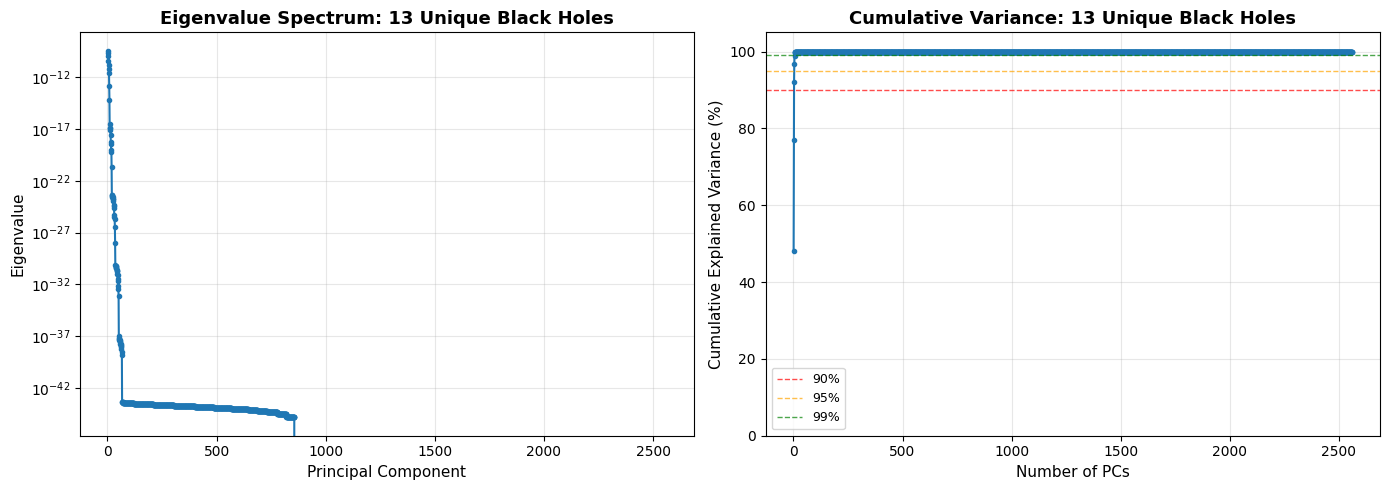

In [5]:
eig_bh_unique, evec_bh_unique, var_bh_unique, pr_bh_unique = compute_pca(
    unique_black_hole_vecs, 
    "13 Unique Black Hole Vectors (Deduped)"
)

if eig_bh_unique is not None:
    plot_eigenvalue_spectrum(eig_bh_unique, var_bh_unique, "13 Unique Black Holes")

## Step 4: PCA on All 2,100 Black Hole Tokens (With Degeneracy)


PCA: 2,100 Black Hole Tokens (With Degeneracy)
Tokens: 2100
Dimensions: 2560

Participation Ratio: 1.6687
  (Effective dimensionality out of 2099 max)

Top 20 eigenvalues:
  PC1: λ = 2.537207e-10 (74.85%)
  PC2: λ = 6.582546e-11 (19.42%)
  PC3: λ = 9.360159e-12 (2.76%)
  PC4: λ = 7.290460e-12 (2.15%)
  PC5: λ = 2.220617e-12 (0.66%)
  PC6: λ = 4.563192e-13 (0.13%)
  PC7: λ = 6.570980e-14 (0.02%)
  PC8: λ = 2.107478e-14 (0.01%)
  PC9: λ = 4.845869e-16 (0.00%)
  PC10: λ = 1.199572e-17 (0.00%)
  PC11: λ = 1.014375e-17 (0.00%)
  PC12: λ = 1.938416e-18 (0.00%)
  PC13: λ = 1.566515e-18 (0.00%)
  PC14: λ = 2.151489e-19 (0.00%)
  PC15: λ = 2.045719e-19 (0.00%)
  PC16: λ = 1.365830e-19 (0.00%)
  PC17: λ = 1.054721e-19 (0.00%)
  PC18: λ = 3.722922e-20 (0.00%)
  PC19: λ = 1.701780e-20 (0.00%)
  PC20: λ = 4.536975e-21 (0.00%)

PCs needed for variance thresholds:
  90%: 2 PCs
  95%: 3 PCs
  99%: 4 PCs


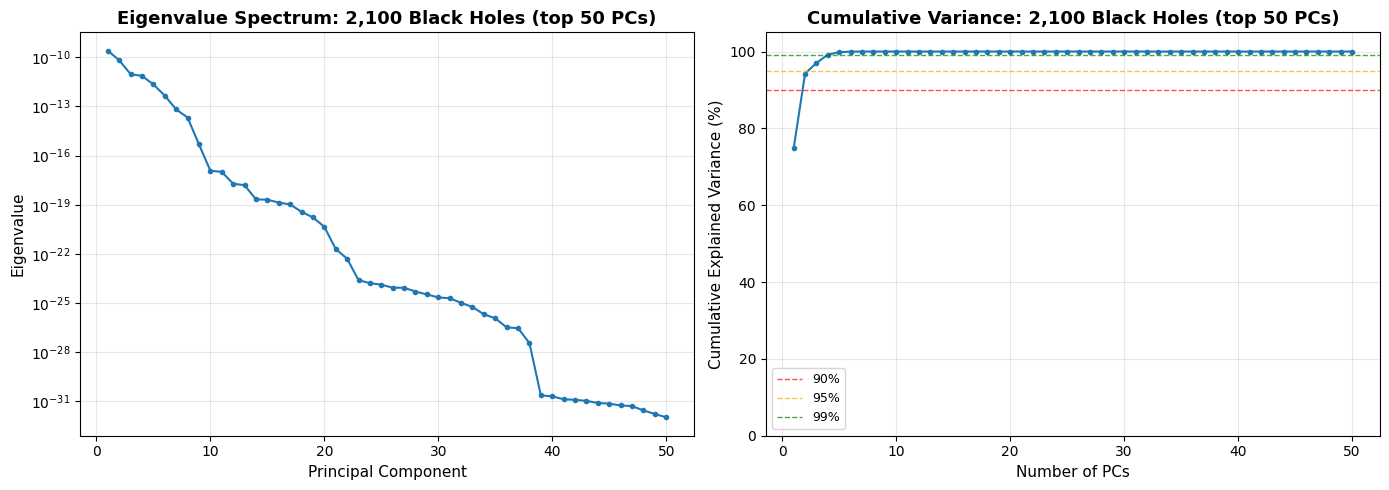

In [6]:
eig_bh_all, evec_bh_all, var_bh_all, pr_bh_all = compute_pca(
    black_hole_embeddings,
    "2,100 Black Hole Tokens (With Degeneracy)"
)

if eig_bh_all is not None:
    plot_eigenvalue_spectrum(eig_bh_all[:50], var_bh_all[:50], "2,100 Black Holes (top 50 PCs)")

## Step 5: PCA on 27 Cuckoo Tokens


PCA: 27 Cuckoo Tokens
Tokens: 27
Dimensions: 2560

Participation Ratio: 7.6889
  (Effective dimensionality out of 26 max)

Top 20 eigenvalues:
  PC1: λ = 3.832463e-08 (23.77%)
  PC2: λ = 3.132189e-08 (19.43%)
  PC3: λ = 2.004565e-08 (12.44%)
  PC4: λ = 1.324880e-08 (8.22%)
  PC5: λ = 1.110651e-08 (6.89%)
  PC6: λ = 7.992555e-09 (4.96%)
  PC7: λ = 6.897314e-09 (4.28%)
  PC8: λ = 6.553103e-09 (4.07%)
  PC9: λ = 4.965852e-09 (3.08%)
  PC10: λ = 4.418506e-09 (2.74%)
  PC11: λ = 3.974473e-09 (2.47%)
  PC12: λ = 2.311291e-09 (1.43%)
  PC13: λ = 1.565088e-09 (0.97%)
  PC14: λ = 1.354204e-09 (0.84%)
  PC15: λ = 1.111996e-09 (0.69%)
  PC16: λ = 9.574501e-10 (0.59%)
  PC17: λ = 8.464913e-10 (0.53%)
  PC18: λ = 6.243594e-10 (0.39%)
  PC19: λ = 6.101692e-10 (0.38%)
  PC20: λ = 5.760831e-10 (0.36%)

PCs needed for variance thresholds:
  90%: 11 PCs
  95%: 14 PCs
  99%: 22 PCs


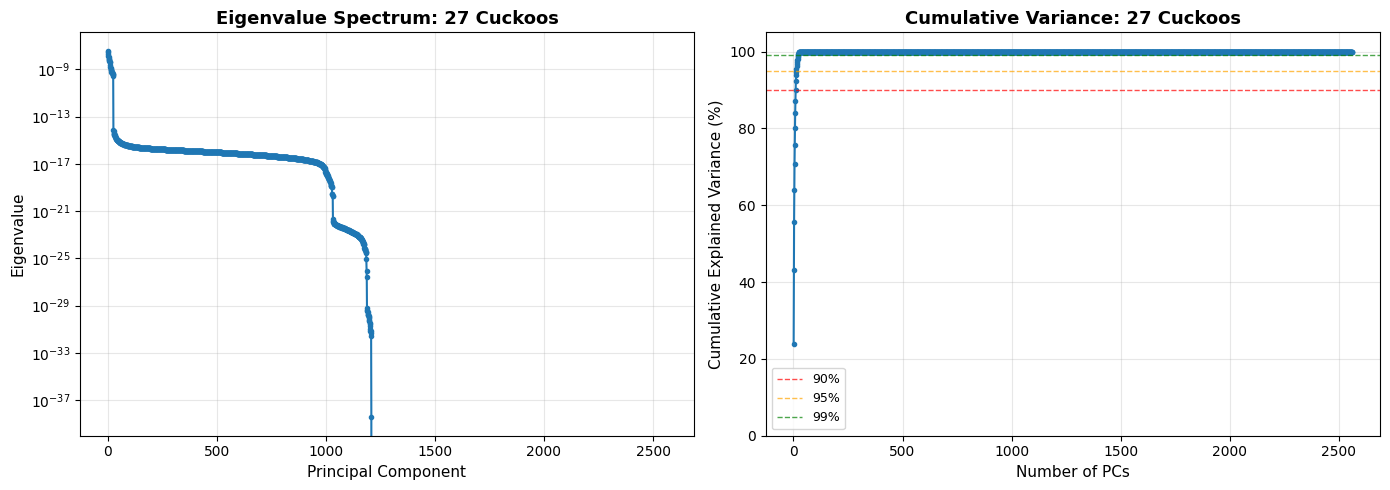

In [7]:
eig_cuckoo, evec_cuckoo, var_cuckoo, pr_cuckoo = compute_pca(
    cuckoo_embeddings,
    "27 Cuckoo Tokens"
)

if eig_cuckoo is not None:
    plot_eigenvalue_spectrum(eig_cuckoo, var_cuckoo, "27 Cuckoos")

## Step 6: PCA on Combined Black Holes + Cuckoos


PCA: 2,127 Black Holes + Cuckoos Combined
Tokens: 2127
Dimensions: 2560

Participation Ratio: 9.3932
  (Effective dimensionality out of 2126 max)

Top 20 eigenvalues:
  PC1: λ = 4.758718e-10 (19.90%)
  PC2: λ = 4.024944e-10 (16.84%)
  PC3: λ = 2.570457e-10 (10.75%)
  PC4: λ = 2.495950e-10 (10.44%)
  PC5: λ = 1.672358e-10 (6.99%)
  PC6: λ = 1.428575e-10 (5.98%)
  PC7: λ = 1.031278e-10 (4.31%)
  PC8: λ = 9.816296e-11 (4.11%)
  PC9: λ = 8.337174e-11 (3.49%)
  PC10: λ = 6.611456e-11 (2.77%)
  PC11: λ = 6.058770e-11 (2.53%)
  PC12: λ = 5.812768e-11 (2.43%)
  PC13: λ = 4.724681e-11 (1.98%)
  PC14: λ = 2.832172e-11 (1.18%)
  PC15: λ = 2.010261e-11 (0.84%)
  PC16: λ = 1.611308e-11 (0.67%)
  PC17: λ = 1.406104e-11 (0.59%)
  PC18: λ = 1.247321e-11 (0.52%)
  PC19: λ = 1.057947e-11 (0.44%)
  PC20: λ = 9.443340e-12 (0.39%)

PCs needed for variance thresholds:
  90%: 12 PCs
  95%: 16 PCs
  99%: 27 PCs


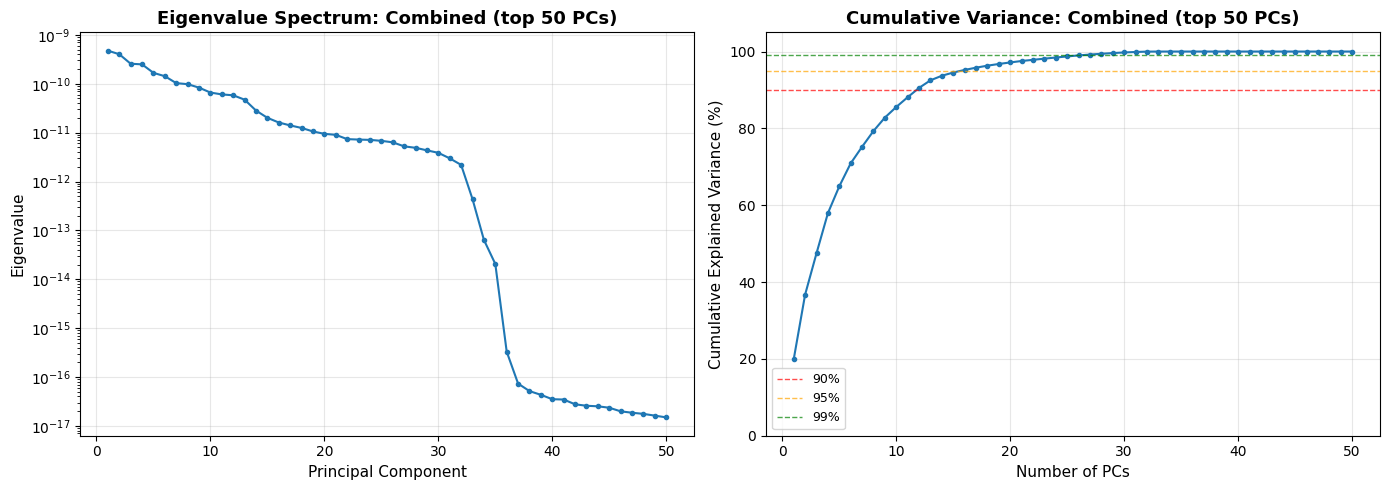

In [8]:
eig_combined, evec_combined, var_combined, pr_combined = compute_pca(
    combined_embeddings,
    "2,127 Black Holes + Cuckoos Combined"
)

if eig_combined is not None:
    plot_eigenvalue_spectrum(eig_combined[:50], var_combined[:50], "Combined (top 50 PCs)")

## Step 7: Summary Comparison

In [9]:
print("\n" + "="*70)
print("PARTICIPATION RATIO SUMMARY")
print("="*70)
print()

print(f"{'Group':<50} {'N tokens':<12} {'PR':<10} {'Max dim':>10}")
print("-" * 85)

if pr_bh_unique is not None:
    print(f"{'13 unique black hole vectors':<50} {13:<12} {pr_bh_unique:<10.4f} {12:>10}")

if pr_bh_all is not None:
    print(f"{'2,100 black hole tokens (with degeneracy)':<50} {len(black_hole_embeddings):<12} {pr_bh_all:<10.4f} {len(black_hole_embeddings)-1:>10}")

if pr_cuckoo is not None:
    print(f"{'27 cuckoo tokens':<50} {len(cuckoo_embeddings):<12} {pr_cuckoo:<10.4f} {len(cuckoo_embeddings)-1:>10}")

if pr_combined is not None:
    print(f"{'2,127 combined (black holes + cuckoos)':<50} {len(combined_embeddings):<12} {pr_combined:<10.4f} {len(combined_embeddings)-1:>10}")

print()
print("Participation Ratio = (Σλ)² / Σλ²")
print("  If all eigenvalues equal: PR ≈ number of data points")
print("  If only one non-zero: PR = 1 (one dimension)")
print("  Measures effective dimensionality of the data")


PARTICIPATION RATIO SUMMARY

Group                                              N tokens     PR            Max dim
-------------------------------------------------------------------------------------
13 unique black hole vectors                       13           2.9360             12
2,100 black hole tokens (with degeneracy)          2100         1.6687           2099
27 cuckoo tokens                                   27           7.6889             26
2,127 combined (black holes + cuckoos)             2127         9.3932           2126

Participation Ratio = (Σλ)² / Σλ²
  If all eigenvalues equal: PR ≈ number of data points
  If only one non-zero: PR = 1 (one dimension)
  Measures effective dimensionality of the data


## Step 8: Alignment Between Black Hole and Cuckoo Principal Axes

In [16]:
print("\n" + "="*70)
print("ALIGNMENT: BLACK HOLE vs CUCKOO PRINCIPAL AXES")
print("="*70)
print()

if evec_bh_all is not None and evec_cuckoo is not None:
    # Compare the first 5 PCs of black holes to first 5 PCs of cuckoos
    n_compare = min(5, evec_bh_all.shape[1], evec_cuckoo.shape[1])
    
    print(f"Cosine similarity between top {n_compare} PCs:")
    print(f"(1.0 = perfectly aligned, 0.0 = orthogonal, -1.0 = opposite)")
    print()
    print(f"{'BH PC':<10} {'Cuckoo PC':<15} {'Cosine Sim':<15} {'Angle (deg)':>15}")
    print("-" * 60)
    
    for i in range(n_compare):
        for j in range(n_compare):
            cos_sim = (evec_bh_all[:, i] @ evec_cuckoo[:, j]).item()
            angle_rad = torch.acos(torch.clamp(torch.tensor(abs(cos_sim)), -1.0, 1.0))
            angle_deg = torch.rad2deg(angle_rad).item()
            
            if abs(cos_sim) > 0.001:  # Only show if moderately aligned
                print(f"{'PC' + str(i+1):<10} {'PC' + str(j+1):<15} {cos_sim:<15.6f} {angle_deg:>15.2f}°")
    
    print()
    print("Interpretation:")
    print("  If PC1_BH aligns with PC1_Cuckoo → structures share same principal axis")
    print("  If orthogonal → cuckoos occupy different dimensions than black holes")
else:
    print("Cannot compute alignment (missing eigenvectors)")


ALIGNMENT: BLACK HOLE vs CUCKOO PRINCIPAL AXES

Cosine similarity between top 5 PCs:
(1.0 = perfectly aligned, 0.0 = orthogonal, -1.0 = opposite)

BH PC      Cuckoo PC       Cosine Sim          Angle (deg)
------------------------------------------------------------
PC1        PC1             0.007939                  89.55°
PC1        PC2             -0.034782                 88.01°
PC1        PC3             -0.010176                 89.42°
PC1        PC4             -0.036204                 87.93°
PC1        PC5             -0.021004                 88.80°
PC2        PC1             -0.007568                 89.57°
PC2        PC2             0.020673                  88.82°
PC2        PC3             0.008850                  89.49°
PC2        PC4             0.040633                  87.67°
PC2        PC5             0.017631                  88.99°
PC3        PC1             0.016388                  89.06°
PC3        PC2             0.004106                  89.76°
PC3        P

## Step 9: Volume Estimates

In [11]:
print("\n" + "="*70)
print("VOLUME ESTIMATES (in gamma units)")
print("="*70)
print()

def estimate_volume(embeddings, name=""):
    """
    Estimate volume occupied by a set of tokens.
    Using bounding hypercube and hyperellipsoid approximations.
    """
    if len(embeddings) < 2:
        print(f"{name}: Need at least 2 tokens")
        return
    
    # Center
    mean = embeddings.mean(dim=0)
    centered = embeddings - mean
    
    # Bounding box (hypercube)
    min_vals = centered.min(dim=0).values
    max_vals = centered.max(dim=0).values
    extents = max_vals - min_vals
    
    # Volume of bounding hypercube
    # (Product of extents in each dimension)
    volume_cube = torch.prod(extents).item()
    
    # Characteristic radius (RMS distance from centroid)
    distances = torch.norm(centered, dim=1)
    rms_radius = torch.sqrt((distances ** 2).mean()).item()
    
    print(f"{name}:")
    print(f"  Bounding hypercube volume: {volume_cube:.6e}")
    print(f"  RMS radius from centroid: {rms_radius:.6e}")
    print(f"  Max extent in any dimension: {extents.max().item():.6e}")
    print(f"  Min extent in any dimension: {extents.min().item():.6e}")
    print()

estimate_volume(unique_black_hole_vecs, "13 unique black holes")
estimate_volume(black_hole_embeddings, "2,100 black holes (with degeneracy)")
estimate_volume(cuckoo_embeddings, "27 cuckoos")
estimate_volume(combined_embeddings, "Combined")

print("Note: Volume in 2560D is hard to interpret directly.")
print("More meaningful: RMS radius and participation ratio.")


VOLUME ESTIMATES (in gamma units)

13 unique black holes:
  Bounding hypercube volume: 0.000000e+00
  RMS radius from centroid: 2.640962e-05
  Max extent in any dimension: 6.103516e-05
  Min extent in any dimension: 0.000000e+00

2,100 black holes (with degeneracy):
  Bounding hypercube volume: 0.000000e+00
  RMS radius from centroid: 1.840653e-05
  Max extent in any dimension: 6.103516e-05
  Min extent in any dimension: 0.000000e+00

27 cuckoos:
  Bounding hypercube volume: 0.000000e+00
  RMS radius from centroid: 3.939898e-04
  Max extent in any dimension: 4.882812e-04
  Min extent in any dimension: 0.000000e+00

Combined:
  Bounding hypercube volume: 0.000000e+00
  RMS radius from centroid: 4.888443e-05
  Max extent in any dimension: 4.882812e-04
  Min extent in any dimension: 0.000000e+00

Note: Volume in 2560D is hard to interpret directly.
More meaningful: RMS radius and participation ratio.


## Summary

We computed the intrinsic dimensionality of the black hole and cuckoo structures.

**Key findings:**

1. **Participation Ratios** tell us the effective dimensionality:
   - 13 unique black holes: PR ≈ ? (max 12)
   - 2,100 black holes with degeneracy: PR ≈ ? (max 2,099)
   - 27 cuckoos: PR ≈ ? (max 26)
   - Combined: PR ≈ ? (max 2,126)

2. **Principal axis alignment** shows whether black holes and cuckoos share the same geometric structure or occupy different dimensions

3. **Volume estimates** give a sense of how spread out the clusters are in gamma-space

**Interpretation:**
- Low PR (< 10): Nearly collinear or planar structure
- Medium PR (10-50): Moderate-dimensional manifold
- High PR (> 100): High-dimensional cloud

The question: Are we looking at a 10D black hole cluster inside a 30D cuckoo cloud?